In [1]:
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)

(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [2]:
x_train_full = (np.expand_dims(x_train_full / 255, axis = -1)).astype(np.float32) 
x_test = np.expand_dims(x_test / 255, axis = -1).astype(np.float32)
x_train, y_train = x_train_full[:50000], y_train_full[:50000]
x_valid, y_valid = x_train_full[50000:], y_train_full[50000:]
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_set = train_set.shuffle(10000, seed = 42)
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_set

<_ShuffleDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

In [3]:
from tensorflow.train import BytesList, FloatList, Int64List, Feature, Features, Example
from contextlib import ExitStack

def create_example(image, label):
    img = tf.io.serialize_tensor(image)
    return Example(features = Features(feature = {"image": Feature(bytes_list = BytesList(value = [img.numpy()])), 
                                                 "label": Feature(int64_list = Int64List(value = [label]))}))

def write_records(name, dataset, n_files = 10):
    paths = ["tfrecords/{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_files) for index in range(n_files)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        for index, (image, label) in dataset.enumerate():
            file = index % n_files
            example = create_example(image, label)
            writers[file].write(example.SerializeToString())
    return paths

train_paths = write_records("mnist.train", train_set)
valid_paths = write_records("mnist.valid", valid_set)
test_paths = write_records("mnist.test", test_set)

In [4]:
def preprocess(tfrecord):
    features = {"image" : tf.io.FixedLenFeature([], tf.string, default_value = ""),
               "label" : tf.io.FixedLenFeature([], tf.int64, default_value = -1)}
    example = tf.io.parse_single_example(tfrecord, features)
    image = tf.io.parse_tensor(example["image"], out_type = tf.float32)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, shape = [28, 28, 1])
    return image, example["label"]

def mnist(filepaths, n_read_threads = 5, shuffle_buffer_size = None, n_parse_threads = 5, batch_size = 32):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads = n_read_threads)
    print(dataset)
    dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [5]:
train_set = mnist(train_paths, shuffle_buffer_size = 10000)
valid_set = mnist(valid_paths)
test_set = mnist(test_paths)

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


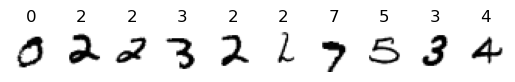

In [6]:
import matplotlib.pyplot as plt

for x, y in train_set.take(1):
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(x[i].numpy(), cmap = "binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [7]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size = 2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        
    def call(self, inputs):
        shape = tf.shape(inputs)
        groups = shape[-1] // self.pool_size
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis = 0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis = -1)

In [36]:
from functools import partial

tf.random.set_seed(42)

defaultConv2d = partial(tf.keras.layers.Conv2D, kernel_size = 3, padding = "same",
                       kernel_initializer = "he_normal", use_bias = False)

def batchnorm_relu():
    return tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ])

model = tf.keras.Sequential([
    defaultConv2d(filters = 64, kernel_size = 3),
    batchnorm_relu(),
    tf.keras.layers.MaxPool2D(),
    defaultConv2d(filters = 64, kernel_size = 3),
    batchnorm_relu(),
    DepthPool(pool_size = 4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_initializer = "he_normal"),
    batchnorm_relu(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = "softmax")
])


In [37]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])

In [38]:
model.fit(train_set, epochs = 10, validation_data = valid_set)

Epoch 1/10
1563/1563 [==============================] - 32s 20ms/step - loss: 0.1651 - accuracy: 0.9524 - val_loss: 0.0525 - val_accuracy: 0.9840
Epoch 2/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0755 - accuracy: 0.9771 - val_loss: 0.0438 - val_accuracy: 0.9862
Epoch 3/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0576 - accuracy: 0.9826 - val_loss: 0.0391 - val_accuracy: 0.9883
Epoch 4/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0473 - accuracy: 0.9857 - val_loss: 0.0503 - val_accuracy: 0.9865
Epoch 5/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0375 - accuracy: 0.9880 - val_loss: 0.0362 - val_accuracy: 0.9896
Epoch 6/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0327 - accuracy: 0.9896 - val_loss: 0.0348 - val_accuracy: 0.9904
Epoch 7/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0281 - accuracy: 0.9911 - val_loss: 0.0314 -

In [39]:
model.evaluate(valid_set)

313/313 [==============================] - 1s 4ms/step - loss: 0.0327 - accuracy: 0.9912


[0.03271827846765518, 0.9911999702453613]

In [41]:
model.save_weights("model_weights/mnist_weights")